In this mini-course, we study latent dirichlet allocation (LDA) model. Which is another topic modeling technique that is not dependent on deep learning. 

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import nltk
import gensim 
import string
import warnings
import pyLDAvis
import pyLDAvis.gensim

from nltk.corpus import stopwords
import matplotlib.colors as mcolors
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

%matplotlib inline

In [7]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

os.chdir("C:\\Users\\GAO\\GAO_Jupyter_Notebook\\Datasets")

#### I. Prerequisite for LDA - Dirichlet Distributions and Gibbs Sampling

Before we talk about LDA, we need to go over two important mathematical concepts. Dirichlet distribution and Gibbs sampling. 

Let's start with Dirichlet distribution. In probability and statistics, the **Dirichlet distribution** (named after Peter Gustav Lejeune Dirichlet), often denoted $\text{Dir}(\alpha)$ is a family of continuous multivariate probability distributions parameterized by a vector $\alpha$ of positive reals. It is a multivariate generalization of the beta distribution hence its alternative name of **multivariate beta distribution** (MBD). Dirichlet distributions are commonly used as prior distributions in Bayesian statistics, and in fact the Dirichlet distribution is the conjugate prior of the **categorical distribution** (also known as the **generalized Bernoulli distribution**) and **multinomial distribution**. The infinite-dimensional generalization of the Dirichlet distribution is the **Dirichlet process**.

Recall that the Beta distribution is a family of continuous probability distributions defined on the interval $[0,1]$, parameterized by two positive shape parameters, denoted by $\alpha, \beta$ that appear as exponents of the random variable and control the shape of the distribution. In Bayesian inference, the Beta distribution is the conjugate prior probability distribution for the Bernoulli, binomial, negative binomial and geometric distributions. The Beta distribution is a suitable model for the random behavior of percentages and proportions. The pdf of a Beta random variable is given by $f(x;\alpha_{1},\alpha_{2})=\frac{1}{B(\alpha_{1}, \alpha_{2})}x^{\alpha_{1}-1}(1-x)^{\alpha_{2}-1}$ with the beta function defined as $B(\alpha_{1}, \alpha_{2})=\frac{\Gamma(\alpha_{1})\Gamma(\alpha_{2})}{\Gamma(\alpha_{1}+\alpha_{2})}$ (we will see that the Beta function can be generalized from the bivariate case to multivariate case easily through the Gamma function $\Gamma(.)$). Let's compare it with the Dirichlet distribution. Define $x=(x_{1},...x_{K}) \in \mathbb{R}^{K}$ and $\alpha=(\alpha_{1},...\alpha_{K}) \in \mathbb{R}^{K}$. Then the pdf of a Dirichlet distribution is given by $f(x;\alpha)=\frac{1}{B(\alpha)}\prod_{k=1}^{K}x_{k}^{\alpha_{k}-1}$. The functional form of the Dirichlet pdf is very similar to that of Beta distribution. The support of the Dirichlet distribution is the set of $K$-dimensional vectors $x$ whose entries are real numbers in the interval (0,1) such that  the sum of the coordinates is equal to 1 ($\sum_{k=1}^{K}x_{k}=1$). These can be viewed as the probabilities of a $K$-way categorical event. Another way to express this is that the domain of the Dirichlet distribution is itself a set of probability distributions, specifically the set of $K$-dimensional discrete distributions. The Dirichlet distribution is a convenient distribution on the simplex—it is in the exponential family, has finite dimensional sufficient statistics, and is conjugate to the multinomial distribution. Wikipedia has a good explanation and more in-depth discussion of the Dirichlet distribution.

Now let's talk about Gibbs sampling. **Gibbs sampling** is a **Markov chain Monte Carlo (MCMC)** algorithm for obtaining a sequence of observations which are approximated from a specified multivariate probability distribution, when direct sampling is difficult. This sequence can be used to approximate the joint distribution (e.g., to generate a histogram of the distribution); to approximate the marginal distribution of one of the variables, or some subset of the variables (for example, the unknown parameters or latent variables); or to compute an integral (such as the expected value of one of the variables). Typically, some of the variables correspond to observations whose values are known, and hence do not need to be sampled. Gibbs sampling is commonly used as a means of statistical inference, especially Bayesian inference. It is a randomized algorithm and is an alternative to deterministic algorithms for statistical inference such as the expectation-maximization algorithm (EM).

In its basic version, Gibbs sampling is a special case of the **Metropolis–Hastings algorithm**. However, in its extended versions (such as blocked Gibbs sampling, collapsed Gibbs sampling etc.), it can be considered a general framework for sampling from a large set of variables by sampling each variable (or in some cases, each group of variables) in turn, and can incorporate the Metropolis–Hastings algorithm (or more sophisticated methods such as slice sampling, adaptive rejection sampling and adaptive rejection Metropolis algorithms) to implement one or more of the sampling steps.

Gibbs sampling is applicable when the joint distribution is not known explicitly or is difficult to sample from directly, but the conditional distribution of each variable is known and is easy (or at least, easier) to sample from. The Gibbs sampling algorithm generates an instance from the distribution of each variable in turn, conditional on the current values of the other variables. It can be shown that the sequence of samples constitutes a Markov chain, and the stationary distribution of that Markov chain is just the sought-after joint distribution. This is why Gibbs sampling is particularly well-adapted to sampling the posterior distribution of a Bayesian network, since Bayesian networks are typically specified as a collection of conditional distributions. 

The idea in Gibbs sampling is to generate posterior samples by sweeping through each variable (or block of variables) to sample from its conditional distribution with the remaining variables fixed to their current values. As a generic example, suppose we have 3 random variables $x_{1}, x_{2}, x_{3}$. We start by setting these variables to their initial values $x_{1}^{(0)}, x_{2}^{(0)}, x_{3}^{(0)}$ (often values sampled from a prior distribution $\pi(.)$). At iteration $s$, we sample $x_{1}^{(s)} \thicksim Pr(x_{1}|x_{2}^{(s-1)},x_{3}^{(s-1)})$, $x_{2}^{(s)} \thicksim Pr(x_{2}|x_{1}^{(s-1)},x_{3}^{(s-1)})$, and $x_{3}^{(s)} \thicksim Pr(x_{3}|x_{1}^{(s-1)},x_{2}^{(s-1)})$. This process continues until "convergence" (the sample values have the same distribution as if they were sampled from the true posterior joint distribution. 

The exact algorithm of Gibbs sampling differs slightly from the description above in that we sample each component of the vector from the distribution of that component conditioned on all other components _sampled so far_ (the keyword is 'so far'). To ensure good results, we revise the algorithm in the following way: at iteration $s$, we sample $x_{1}^{(s)} \thicksim Pr(x_{1}|x_{2}^{(s-1)},x_{3}^{(s-1)})$, $x_{2}^{(s)} \thicksim Pr(x_{2}|x_{1}^{(s)},x_{3}^{(s-1)})$, and $x_{3}^{(s)} \thicksim Pr(x_{3}|x_{1}^{(s)},x_{2}^{(s)})$. This way, the samples can approximate the joint distribution of all variables, and the marginal distribution of any subset of variables can be approximated by simply considering the samples for that subset of variables, ignoring the rest.

It is common to ignore some number of samples at the beginning (the so-called **burn-in period**), and then consider only every m-th sample when averaging values to compute an expectation. For example, the first 1000 samples might be ignored, and then every 100th sample averaged, throwing away all the rest. The reason for this is that (1) the stationary distribution of the Markov chain is the desired joint distribution over the variables, but it may take a while for that stationary distribution to be reached; (2) successive samples are not independent of each other but form a Markov chain with some amount of correlation. The process of **simulated annealing** is often used to reduce the 'random walk' behavior in the early part of the sampling process (i.e. the tendency to move slowly around the sample space, with a high amount of autocorrelation between samples, rather than moving around quickly, as is desired). Other techniques that may reduce autocorrelation are collapsed Gibbs sampling and blocked Gibbs sampling etc. A good discussion about the details of the Gibbs samplings and MCMC can be found here: https://ermongroup.github.io/cs323-notes/ which discusses Gibbs sampling, Metropolis–Hastings algorithm as well as the theories of the MCMC. Wikipedia has a good description of the algorithm as well (see below):

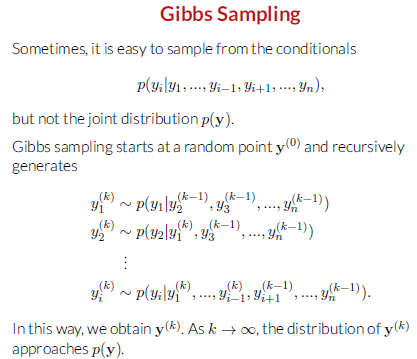

In [3]:
from IPython.display import Image
Image("Gibbs sampling algorithm.PNG", width=400, height=400)

#### II. Latent Dirichlet Allocation (LDA)

Now we can discuss LDA more in detail. The basic idea of LDA is that LDA is a generative probabilistic model for collections of discrete data such as text corpora. LDA is a three-level hierarchical Bayesian model, in which each item of a collection is modeled as a finite mixture over an underlying set of topics. Each topic is, in turn, modeled as an infinite mixture over an underlying set of topic probabilities. Intuitively, topics form a hidden layer in the logic tree and the framework looks like this:

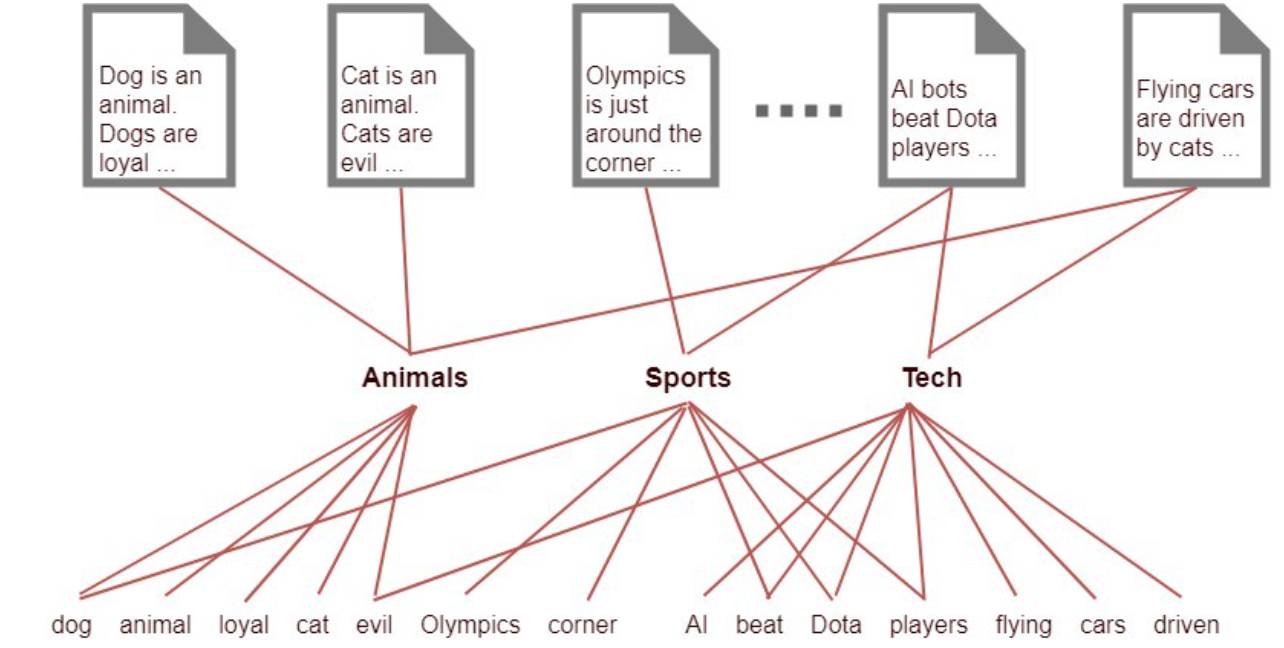

In [8]:
from IPython.display import Image
Image(filename="LDA intuition.PNG", width=400, height=400)

Notice that the topics we use here ('Animals', 'Sports', 'Tech') are imaginary. In the real solution, you won’t have such topics written out explicitly but something like (0.3\*Cats,0.4\*Dogs,0.2\*Loyal, 0.1\*Evil) representing the topic 'Animals'. That is, as mentioned before, each document is a distribution of words. This also tells us that LDA does not care the order of the words in the document. Usually, LDA use the bag-of-words feature representation to represent a document.

To have a deeper understanding about LDA, let's go over some mathematics. This section comes from the original LDA paper by Blei, Ng, and Jordan (2003):

##### Definition:
A finite set of random variables $z_{1},...z_{N}$ is said to be **exchangeable** if the joint distribution is invariant to permutation; that is, if $\pi(.)$ is a permutation of the integers from 1 to $N$, then $Pr(z_{1},...z_{N}) = Pr(z_{\pi(1)},...z_{\pi(N)})$. An infinite sequence of random variables is infinitely exchangeable if every finite subsequence is exchangeable.

##### Theorem (de Finetti):
The joint distribution of an infinitely exchangeable sequence of random variables is as if a random parameter were drawn from some distribution and then the random variables in question were independent and identically distributed, conditioned on that parameter.

A classic representation theorem due to de Finetti (1990) establishes that any collection of exchangeable random variables has a representation as a mixture distribution—in general an infinite mixture. Thus, if we wish to consider exchangeable representations for documents and words, we need to consider mixture models that capture the exchangeability of both words and documents. This line of thinking motivates the assumption of the LDA model.

An assumption of exchangeability is not equivalent to an assumption that the random variables are independent and identically distributed. Rather, exchangeability essentially can be interpreted as meaning 'conditionally independent and identically distributed', where the conditioning is with respect to an underlying latent parameter of a probability distribution. Conditionally, the joint distribution of the random variables is simple and factored while marginally over the latent parameter, the joint distribution can be quite complex. Thus, while an assumption of exchangeability is clearly a major simplifying assumption in the domain of text modeling, and its principal justification is that it leads to methods that are computationally efficient, the exchangeability assumption does not necessarily lead to methods that are restricted to simple frequency counts or linear operations. By taking the de Finetti theorem seriously, we can capture significant intra-document statistical structure via the mixing distribution.

##### Definition:
We adopt the following notation under the LDA framework:

   1. A word is the basic unit of discrete data, defined to be an item from a vocabulary indexed by $v=1,2,...V$. We represent words using unit-basis vectors that have a single component equal to one and all other components equal to zero. Thus, the $v$th word in the vocabulary is represented by a vector $w$ such that $w_{v}$ = 1 and $w_{u}$ = 0 for $ u \neq v$. In other words, $w=(0,0,...1,0,..0)$ where $w_{v}=1, w_{u}=0, \forall u \neq v, dim(w)=V$. 
   2. A document is a sequence of $N$ words denoted by $D = (w_{1},w_{2},...w_{N})$, where $w_{n}$ is the $n$th word in the sequence indexed by $n=1,2,...N$.
   3. A corpus is a collection of $M$ documents denoted by $C=\{D_{1}, D_{2},...D_{M}\}$ indexed by $m=1,2,...M$.
   4. A topic from a set of $K$ topics is denoted by $z$. A topic is a distribution of words. For example, Animal = (0.3Cats, 0.4Dogs, 0AI, 0.2Loyal, 0.1Evil).
   
Thus, summarizing what we have so far, a document $D_{m}$ in a corpus $C$ composed of $M$ document is a sequence of $N=N(m)$ words denoted by $D_{m} = (w_{1},w_{2},...w_{N(m)})$, where $w_{n}$ is the $n$th word in the sequence indexed by $n=1,2,...N(m)$, and $w_{n}$ is a vector with dimension $V$, and if the $v$th word is contained in this vector, then $w_{n}=(0,0,...1,0,..0)$ where the $v$th component is 1 and the rest of the components are all 0s. 

The notation above is fairly consistent with the ones used in the tutorial "Intuitive Guide to Latent Dirichlet Allocation" in the 'Towards Data Science' blog (c.f. https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-latent-dirichlet-allocation-437c81220158), with minor revisions. Our goal here is to find a probabilistic model of a corpus that not only assigns high probability to members of the corpus, but also assigns high probability to other 'similar' documents. LDA assumes the following generative process for each document D in a corpus C:

   1. Choose $N \sim Poisson(\xi)$.
   2. Choose $\theta \sim Dir(\alpha)$. Assume the dimensionality $K$ of the Dirichlet distribution (and thus the dimensionality of the topic $z$) is known and fixed. Here, you can think of $\alpha$ as a distribution related parameter that governs what the distribution of topics is for all the documents in the corpus looks like. So $\theta$ is the $K$-dimensional Dirichlet random variable which dictates the topic distribution. 
   3. For each of the words: 
      - Choose a topic $z_{n} \sim \text{Multinomial}(\theta)$.
      - Choose a word $w_{n}$ from $p(w_{n}|z_{n},\mathcal{B})$, a multinomial probability conditioned on the topic $z_{n}$. Here, $\mathcal{B}$ is a matrix with size $K$-by-$V$ with its elements $\beta_{i,j}=Pr(w_{nj}=1|z_{i}=1)$ (here $w_{nj}=1$ denotes the $j$th component of the word $w_{n}$). So you can think of as probability of $i$th topic containing $j$th word.

As we have seen before, a $K$-dimensional Dirichlet random variable $\theta$ can take values in the $(K−1)$-simplex (a $K$-vector $\theta$ lies in the $(K−1)$-simplex if $\theta_{k} \ge 0$, $\sum_{k=1}^{K}\theta_{k}=1$), and has the following probability density on this simplex: $f(\theta;\alpha)=\frac{1}{B(\alpha)}\prod_{k=1}^{K}\theta_{k}^{\alpha_{k}-1}=\frac{\Gamma(\sum_{k=1}^{K}\alpha_{k})}{\prod_{k=1}^{K}\Gamma(\alpha_{k})}\prod_{k=1}^{K}\theta_{k}^{\alpha_{k}-1}$.

So given the parameters $\alpha, \beta$, the joint distribution of a topic mixture $\theta$, a set of $N$ topics $z$, and a document $D$ is given by $Pr(\theta,z,D|\alpha,\mathcal{B}) =Pr(\theta|\alpha)\prod_{n=1}^{N}Pr(z_{n}|\theta)Pr(w_{n}|z_{n}, \mathcal{B})$. Here, what we really care about are the two hyperparameters $\alpha$ and $\mathcal{B}$, the latter of which is a matrix of $\beta_{ij}$'s.

Structures similar to this type of problems are often studied in Bayesian statistical modeling, where they are referred to as **hierarchical models** (Gelman et al., 1995), or more precisely as **conditionally independent hierarchical models** (Kass and Steffey, 1989). Such models are also often referred to as **parametric empirical Bayes models**, a term that refers not only to a particular model structure, but also to the methods used for estimating parameters in the model (Morris, 1983).

In LDA, we assume that words are generated by topics (by fixed conditional distributions) and that those topics are infinitely exchangeable within a document. By de Finetti’s theorem, the probability of a sequence of words and topics must therefore have the form $Pr(D,z)=\int Pr(\theta)(\prod_{n=1}^{N}Pr(z_{n}|\theta)Pr(w_{n}|z_{n})d\theta$, where $\theta$ is the random parameter of a multinomial over topics and we endow $\theta$ with a Dirilecht distribution. 

Estimation of the model requires some Bayesian techniques, including Gibbs sampling. We will not elaborate here. Although the posterior distribution is intractable for exact inference, a wide variety of approximate inference algorithms can be considered for LDA, including Laplace approximation, variational approximation, and Markov chain Monte Carlo. The original paper by Blei, Ng, and Jordan (2003) has more information, and they explained the idea of variational inference. 

From a practical perspective, the most important thing about the model is the choice of hyperparameters. The parameter $\alpha$ sets the prior on the per-document distributions, whereas the $\mathcal{B}$ sets the prior on the per-topic word distributions. High values of $\alpha$ means every document is likely to contain a mixture of most of the topics, and not just a single topic specifically whereas low value means a document is likely to contain a small finite set of topics (so the document is specialized in certain topics, think about the Bible). Similarly, a high value of $\beta$ is likely to contain a mixture of more words, whereas low value implies monotonicity of vocabulary. So high $\alpha$ will make documents more similar to each other, whereas high $\beta$ will make topics more similar to each other. 

Now let's use an example. We will use the Gensim package, which is another powerful NLP package as almost versatile as the NLTK package. Again, we use the example like before. We won't be focusing on the foundations of the Gensim library but now we only care about building LDA model. We will use the "20 NewGroup" dataset from the scikit-learn package.  

In [9]:
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers','footers','quotes'))
print(type(dataset))

documents = dataset.data
print(type(documents))
target_names=dataset.target_names
print(type(target_names))
filenames=dataset.filenames
print(type(filenames))

news_df=pd.DataFrame({'documents':documents})
print(news_df[0:10])

<class 'sklearn.utils.Bunch'>
<class 'list'>
<class 'list'>
<class 'numpy.ndarray'>
                                           documents
0  Well i'm not sure about the story nad it did s...
1  \n\n\n\n\n\n\nYeah, do you expect people to re...
2  Although I realize that principle is not one o...
3  Notwithstanding all the legitimate fuss about ...
4  Well, I will have to change the scoring on my ...
5   \n \nI read somewhere, I think in Morton Smit...
6  \nOk.  I have a record that shows a IIsi with ...
7  \n\n\nSounds like wishful guessing.\n\n\n\n\n'...
8   Nobody is saying that you shouldn't be allowe...
9  \n  I was wondering if anyone can shed any lig...


In [10]:
news_df['clean_doc']=news_df['documents'].str.replace("[^a-zA-Z#]", " ") # removing everything except alphabets
news_df['clean_doc']=news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>=3])) # removing shorter words
news_df['clean_doc']=news_df['clean_doc'].apply(lambda x: x.lower()) # normalizing texts to lower-case
news_df.head()

,documents,clean_doc
0,Well i'm not sure about the story nad it did s...,well not sure about the story nad did seem bia...
1,"\n\n\n\n\n\n\nYeah, do you expect people to re...",yeah you expect people read the faq etc and ac...
2,Although I realize that principle is not one o...,although realize that principle not one your s...
3,Notwithstanding all the legitimate fuss about ...,notwithstanding all the legitimate fuss about ...
4,"Well, I will have to change the scoring on my ...",well will have change the scoring playoff pool...


In [7]:
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split()) # tokenization

detokenized_doc = [] # de-tokenization
for i in range(len(news_df)):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)

news_df['clean_doc'] = detokenized_doc # this is a list
news_df.head(6)

,documents,clean_doc
0,Well i'm not sure about the story nad it did s...,well not sure about the story nad did seem bia...
1,"\n\n\n\n\n\n\nYeah, do you expect people to re...",yeah you expect people read the faq etc and ac...
2,Although I realize that principle is not one o...,although realize that principle not one your s...
3,Notwithstanding all the legitimate fuss about ...,notwithstanding all the legitimate fuss about ...
4,"Well, I will have to change the scoring on my ...",well will have change the scoring playoff pool...
5,"\n \nI read somewhere, I think in Morton Smit...",read somewhere think morton smith jesus the ma...


Recall that we have removed numerals and weird punctuations and we also normalized the texts by lowercasing everything, it only needs to remove stopwords from this point on. 

In [11]:
sw_addendum=["would", "woulnd't", "also", "can", "could", "really", "nothing", "none",
             "much", "many", "yet", "some", "something", "anything", "still", "yet", "already",
             "shall", "shan't",  "may", "might", "nowhere", "anywhere", "somewhere"] # additional stopwords list
sw_nltk=stopwords.words("english")
sw = sw_nltk+sw_addendum
punkt=[l for l in string.punctuation]

rawlist=news_df['clean_doc'].tolist()
print(len(news_df['clean_doc']))

text_to_mine=[]
for j in rawlist:
    doc=nltk.word_tokenize(j)
    doc2=[j.strip() for j in doc if (j not in sw) and (len(j) != 1)] # removing stopwords and words that are too short (length<=1)
    text_to_mine.append(doc2)

11314


The main class we will be using is gensim.models.LdaModel(). Here are some of the important hyperparameters. For the complete list, see the official Gensim documentation:

   - _passes_: number of passes through the corpus during training.
   - _eta_: the same as $beta$ in our previous notes
   - _num_topics_: number of topics 
   - _minimum_probability_: (float, optional) – topics with a probability lower than this threshold will be filtered out.

In [12]:
# text_to_mine = [["a","b","c"], ["d","e","f"]] should look like this: ["a","b","c"] are the tokens of document 1, ["d","e","f"] are the tokens of document 2...

dictionary_LDA = gensim.corpora.Dictionary(text_to_mine)
dictionary_LDA.filter_extremes(no_below=5) # filtering out tokens in the dictionary by their frequency
corpus = [dictionary_LDA.doc2bow(list_of_tokens) for list_of_tokens in text_to_mine]

K = 4 # number of topics (always try even numbers first)
lda_model = gensim.models.LdaModel(corpus, num_topics=K, id2word=dictionary_LDA, random_state=32, passes=10, alpha=[0.001]*K, eta=[0.02]*len(dictionary_LDA.keys()))

In [13]:
for i,topic in lda_model.show_topics(formatted=True, num_topics=K, num_words=25):
    print(str(i)+": "+ topic)
    print()

0: 0.010*"edu" + 0.006*"space" + 0.005*"information" + 0.005*"available" + 0.004*"com" + 0.004*"new" + 0.004*"armenian" + 0.004*"use" + 0.003*"data" + 0.003*"public" + 0.003*"university" + 0.003*"armenians" + 0.003*"pub" + 0.003*"national" + 0.003*"ftp" + 0.003*"research" + 0.003*"mail" + 0.003*"april" + 0.003*"turkish" + 0.003*"list" + 0.003*"key" + 0.002*"health" + 0.002*"nasa" + 0.002*"program" + 0.002*"system"

1: 0.007*"one" + 0.007*"use" + 0.007*"get" + 0.006*"like" + 0.005*"file" + 0.005*"know" + 0.004*"windows" + 0.004*"system" + 0.004*"program" + 0.004*"used" + 0.004*"thanks" + 0.004*"using" + 0.004*"problem" + 0.004*"need" + 0.003*"anyone" + 0.003*"drive" + 0.003*"bit" + 0.003*"time" + 0.003*"please" + 0.003*"new" + 0.003*"good" + 0.003*"work" + 0.003*"output" + 0.003*"window" + 0.003*"want"

2: 0.011*"game" + 0.010*"team" + 0.010*"year" + 0.008*"games" + 0.007*"play" + 0.006*"season" + 0.006*"first" + 0.006*"last" + 0.006*"win" + 0.006*"good" + 0.005*"players" + 0.005*"leagu

To print the % of topics a document is about, we can do the following. Below we want to check the topic distribution of the 3rd document. 

Here is the interpretation. If we see [(1, 0.5173717951813482), (3, 0.43977106196150995)], we interpret it as the following: this current document talks 52% about topic 1, and 44% about topic 3. Note that 4% could not be labelled as existing topics.

In [14]:
lda_model[corpus[2]] # corpus[2] means the 3rd document as our index starts from 0

[(0, 0.094213545), (3, 0.90575004)]

What is the dominant topic and its percentage contribution in each document? In LDA models, each document is composed of multiple topics. But, typically only one of the topics is dominant. The below code extracts this dominant topic for each sentence and shows the weight of the topic and the keywords in a nicely formatted output.

In [15]:
def format_topics_sentences(ldamodel, corpus, texts):
    sent_topics_df = pd.DataFrame() # initializing output

    for i, row_list in enumerate(ldamodel[corpus]): # getting the main topic in each document
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row): # getting the dominant topic, percentage contribution of that topic, and keywords for each document
            if j == 0: 
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    contents = pd.Series(texts) # adding original texts to the end of the output
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=text_to_mine)

df_dominant_topic = df_topic_sents_keywords.reset_index() # further formatting
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Percentage_Contribution', 'Keywords', 'Texts'] # creating column names
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Percentage_Contribution,Keywords,Texts
0,0,3.0,1.0000,"max, people, one, think, know, god, like, say,...","[well, sure, story, nad, seem, biased, disagre..."
1,1,3.0,0.5913,"max, people, one, think, know, god, like, say,...","[yeah, expect, people, read, faq, etc, actuall..."
2,2,3.0,0.9057,"max, people, one, think, know, god, like, say,...","[although, realize, principle, one, strongest,..."
3,3,3.0,0.5528,"max, people, one, think, know, god, like, say,...","[notwithstanding, legitimate, fuss, proposal, ..."
4,4,2.0,0.7304,"game, team, year, games, play, season, first, ...","[well, change, scoring, playoff, pool, unfortu..."
5,5,3.0,0.8739,"max, people, one, think, know, god, like, say,...","[read, think, morton, smith, jesus, magician, ..."
6,6,1.0,1.0000,"one, use, get, like, file, know, windows, syst...","[record, shows, iisi, without, cache, small, e..."
7,7,3.0,0.7706,"max, people, one, think, know, god, like, say,...","[sounds, like, wishful, guessing, called, mean..."
8,8,0.0,0.5543,"edu, space, information, available, com, new, ...","[nobody, saying, allowed, use, msg, force, oth..."
9,9,1.0,0.6806,"one, use, get, like, file, know, windows, syst...","[wondering, anyone, shed, light, electronic, o..."


When working with a large number of documents, you want to know how big the documents are as a whole and by topic. Let’s plot the document word counts distribution:

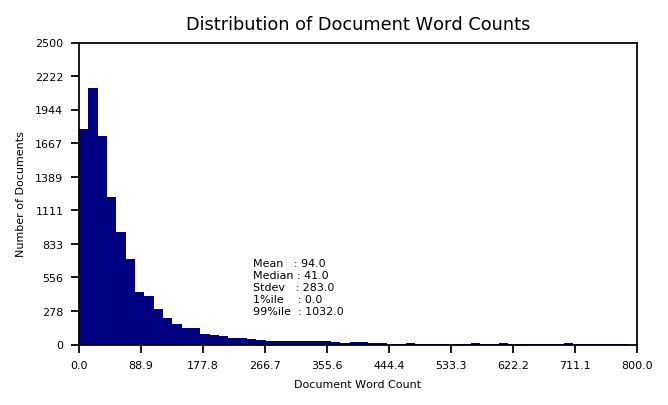

In [16]:
doc_lens = [len(d) for d in df_dominant_topic.Texts]

plt.figure(figsize=(4.5,2.5), dpi=160) # plotting the outside frame
plt.hist(doc_lens, bins = 500, color='navy')
plt.text(250, 650, "Mean   : " + str(round(np.mean(doc_lens))), size=5) # coordinate at 250,450
plt.text(250, 550 , "Median : " + str(round(np.median(doc_lens))), size=5)
plt.text(250, 450, "Stdev   : " + str(round(np.std(doc_lens))), size=5)
plt.text(250, 350, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))), size=5)
plt.text(250, 250, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))), size=5)

plt.xlabel('xlabel', fontsize=5)
plt.ylabel('ylabel', fontsize=5)
plt.gca().set(xlim=(0, 500), ylabel='Number of Documents', xlabel='Document Word Count')
plt.xticks(np.linspace(0,800,10), size=5)
plt.yticks(np.linspace(0,2500,10), size=5)
plt.title('Distribution of Document Word Counts', fontdict=dict(size=8))
plt.show()

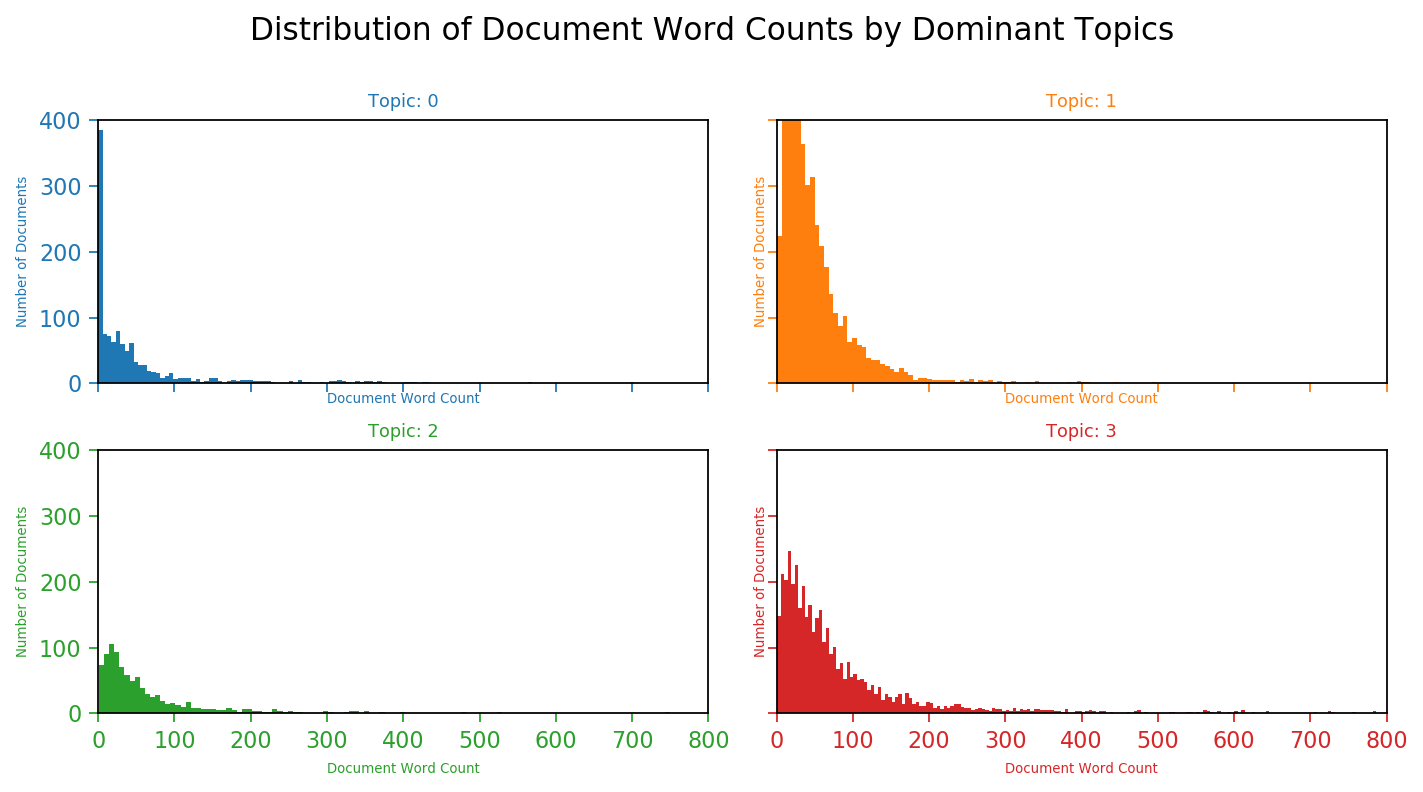

In [17]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2, 2, figsize=(9,5), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Texts]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i], size=4)
    ax.tick_params(axis='x', labelcolor=cols[i], color=cols[i], size=4)
    #sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx()) # kernal denity plot
    ax.set(xlim=(0, 800), ylim=(0, 400))
    ax.set_xlabel('Document Word Count', color=cols[i], size=6)
    ax.set_ylabel('Number of Documents', color=cols[i], size=6)
    ax.set_title('Topic: '+str(i), fontdict=dict(size=8, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.85)
#plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topics', fontsize=14)
plt.show()

### III. Information Theory and NLP

**Information theory** is the scientific study of the quantification, storage, and communication of information. The field was fundamentally established by the works of Harry Nyquist, Ralph Hartley, in the 1920s, and Claude Shannon in the 1940s. The field is at the intersection of probability theory, statistics, computer science, statistical mechanics, information engineering, and electrical engineering.

When it comes to NLP problem, there are many important concepts that involve information theory. A key measure in information theory is **entropy**. Entropy quantifies the amount of uncertainty involved in the value of a random variable or the outcome of a random process. For example, identifying the outcome of a fair coin flip (with two equally likely outcomes) provides less information (lower entropy) than specifying the outcome from a roll of a die (with six equally likely outcomes). Intuitively, the entropy of a discrete random variable $x$ is a measure of the amount of uncertainty associated with the value of $x$ when only its distribution is known.

Information theory is based on probability theory and statistics. Information theory often concerns itself with measures of information of the distributions associated with random variables. So the fundamental thing we need to understand how we should measure information. A common unit of information is the **bit**, based on the **binary logarithm**:

##### Definition:

The binary logarithm $(log_{2}n)$ is the power to which the number 2 must be raised to obtain the value $n$. That is, for any real number $x$, $x=(log_{2}n)$ iff $2^{x}=n$. 

For example, the binary logarithm of 1 is 0, the binary logarithm of 2 is 1, the binary logarithm of 4 is 2, and the binary logarithm of 32 is 5. The bit represents a logical state with one of two possible values. These values are most commonly represented as either "1" or "0".

There are other units in information theory. One example is **nat**, which is based on the natural logarithm (base $e$); another one is the **decimal digit**, which is based on the **common logarithm** (base 10).

Based on the probability mass function (pmf) of each source symbol to be communicated, the **Shannon entropy** $H$, in units of bits (per symbol), is given by $H=-\sum_{j}p_{j}log_{2}p_{j}$, where $p_{j}$ is the probability of occurrence of the j-th possible value of the source symbol. There are other bases that can be used other than 2. For exapmle, logarithm of base $2^{8}=256$ will produce a measurement in $bytes$ per symbol, and a logarithm of base 10 will produce a measurement in decimal digits per symbol. The entropy of a source that emits a sequence of $V$ symbols that are independent and identically distributed (iid) is $VH$ bits (per message of $V$ symbols). If the source data symbols are identically distributed but not independent, the entropy of a message of length N will be less than $VH$.


In [19]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # computing perplexity: a measure of how good the model is (lower the better)


Perplexity:  -9.821775733756375


Information theory has a lot of applications in NLP. For example, we can define a concept called **perplexity**, which is a measurement of how well a probability distribution or probability model predicts a sample. It may be used to compare probability models. A low perplexity indicates the probability distribution is good at predicting the sample. Speicifically, the perplexity of a discrete probability distribution $p(.)$ is defined as $2^{H}$ where $H$ is the Shannon's entropy (in bits) of the distribution. The base need not be 2: the perplexity is independent of the base, provided that the entropy and the exponentiation use the same base. In natural language processing, perplexity is a way of evaluating language models. A language model is a probability distribution over entire sentences or texts.

Another important metric in NLP is **coherence**. Simply put,  a set of statements or facts is said to be coherent, if they support each other. Thus, a coherent fact set can be interpreted in a context that covers all or most of the facts. There are different kinds of coherence metrics in the Gensim library. Besides the official Gensim document, there are some other good sources for discussion on coherence on the internet, for example:

   - https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
   - https://palmetto.demos.dice-research.org/

The study of coherence is still a young field in NLP. And there are many metrics that have been proposed. For exapmle, discussions upon coherence can be found here related to 'u_mass': https://stackoverflow.com/questions/62032372/coherence-score-u-mass-18-is-good-or-bad. In general, for this particular type of coherence, the lower the score, the better the coherence. For other types of coherence metric, the direction could be the opposite. This is still an active research area in information theory as well as NLP so we won't cover too much details for now. 

#### IV. PyLDAvis

We can also visualize the topics in a nice way. The visualization below from the 'PyLDAvis' package allows us to compare topics on two reduced dimensions and observe the distribution of words in topics. The interface of the visualization provides:

   - a left panel that depicts a global view of the model (how prevalent each topic is and how topics relate to each other);
   - a right panel containing a bar chart – the bars represent the terms that are most useful in interpreting the topic currently selected (what the meaning of each topic is). Saliency is a measure of how much the term tells you about the topic. The most salient terms are the terms that mostly tell us about what’s going on relative to the topics. 
   
On the left, the topics are plotted as circles, whose centers are defined by the computed distance between topics (projected into 2 dimensions). The prevalence of each topic is indicated by the circle’s area. So the size of the bubble measures the importance of the topics, relative to the data. On the right, two juxtaposed bars showing the topic-specific frequency of each term (in red) and the corpus-wide frequency (in blueish gray). When no topic is selected, the right panel displays the top 30 most salient terms for the dataset. When we increase the number of topics (dictated by the parameter $K$ from the example above), we will see certain topics are clustered together, which indicates the similarity between topics. 

What is cool about this tool is how it determines the most useful terms to interpret a topic (and also how users can interactively change it). The engineer of this tool  proposed a measure called **relevance**, which denotes the degree to which a term appears in a particular topic to the exclusion of others. Relevance is based on another metric, **lift**, which is the ratio of a term’s probability within a topic to its margin probability across the corpus. 

Relevance is denoted by $R$, and is controlled by the weight assigned to the probability of a term in a topic relative to its lift, denoted by $\lambda$. When $\lambda=1$, the terms are ranked by their probabilities within the topic while when $\lambda=0$, the terms are ranked only by their lift. The interface allows us to adjust the value of $\lambda$ between 0 and 1. Some research indicated that the optimal $\lambda$ values should be between 0.6 and 0.8. To be more precise, for each word $w$, given a topic-word distribution $g$, a topic $z$ and a weight parameter $\lambda$, relevance of the word $w$ to topic $z$ is calculated as:$R(w,z)=\lambda log(g_{z,w})+(1-\lambda)log(\frac{g_{z,w}}{Pr(w)})$. A lower $\lambda$ gives more importance to the second term (lift), which gives more importance to topic exclusivity. 

In [18]:
vis = pyLDAvis.gensim.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary_LDA)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

Here are some tips of having interpretable LDA results:

   1. If the topics still do not make sense, try increasing passes and iterations, while increasing chunksize to the extent the memory can handle.
   2. Focus on the visualization of the LDA in the 'PyLDAvis' package. The circles represent each topic. The distance between the circles visualizes topic relatedness. These are mapped through dimensionality reduction (PCA/t-SNE) on distances between each topic’s probability distributions into 2D space. This shows whether our model developed distinct topics. Our goal is to tune model parameters and number of topics to minimize circle overlap. Keep in mind that circle size also represents topic prevalence.
   3. Words representing a given topic may be ranked high because they are globally frequent across a corpus. Relevancy score helps prioritize terms that belong more exclusively to a given topic, making the topic more obvious. 
   4. Wisely choose the number of topics. This is a hard task, as there are many ways to evaluate this. One important set of metrics is topic coherence. 

In [16]:
coherence = []
coherence_type='u_mass'
for k in range(4,20):
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel_k = Lda(corpus, num_topics=k, id2word = dictionary_LDA, passes=20, iterations=40, chunksize=200, eval_every = None)
    
    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel_k, texts=text_to_mine, dictionary=dictionary_LDA, coherence=coherence_type)
    coherence.append((k,cm.get_coherence()))
    print('Round', k, ": Coherence score"+coherence_type, ":", cm.get_coherence())

Round 4 : Coherence scoreu_mass : -2.8208485135505406
Round 5 : Coherence scoreu_mass : -3.5735968224185983
Round 6 : Coherence scoreu_mass : -2.86193949911612
Round 7 : Coherence scoreu_mass : -3.426332114652875
Round 8 : Coherence scoreu_mass : -3.2632434626693665
Round 9 : Coherence scoreu_mass : -3.294481222483768
Round 10 : Coherence scoreu_mass : -3.005259939726771
Round 11 : Coherence scoreu_mass : -3.5118373760351584
Round 12 : Coherence scoreu_mass : -3.055429567609234
Round 13 : Coherence scoreu_mass : -3.5369802941654465
Round 14 : Coherence scoreu_mass : -3.500971961500256
Round 15 : Coherence scoreu_mass : -2.867816339698386
Round 16 : Coherence scoreu_mass : -2.899046242364923
Round 17 : Coherence scoreu_mass : -3.399718807533784
Round 18 : Coherence scoreu_mass : -2.765394546641816
Round 19 : Coherence scoreu_mass : -2.8458936258104477


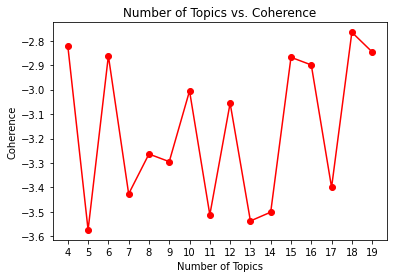

In [17]:
x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

colorcode='red'
plt.plot(x_val, y_val, color=colorcode)
plt.scatter(x_val,y_val, color=colorcode)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()

### References:

##### Topic Modeling In General and Mathematics Background:

   - https://kieranrcampbell.github.io/blog/2016/05/15/gibbs-sampling-bayesian-linear-regression.html
   - https://ermongroup.github.io/cs323-notes/
   - https://palmetto.demos.dice-research.org/
   - A. Gelman, J. Carlin, H. Stern, and D. Rubin (1995). Bayesian data analysis. Chapman & Hall, London.
   - R. Kass and D. Steffey (1989). Approximate Bayesian inference in conditionally independent hierarchical models (parametric empirical Bayes models). Journal of the American Statistical Association, 84 (407):717–726.
   - C. Morris (1983). Parametric empirical Bayes inference: Theory and applications. Journal of the American Statistical Association, 78(381):47–65. With discussion.
   - Roeder, M., Both, A. & Hinneburg, A. (2015). Exploring the Space of Topic Coherence Measures. Proceedings of the eight International Conference on Web Search and Data Mining, Shanghai, February 2-6.


##### LDA:

   - https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-latent-dirichlet-allocation-437c81220158
   - https://towardsdatascience.com/the-complete-guide-for-topics-extraction-in-python-a6aaa6cedbbc  
   - https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21
   - https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
   - https://towardsdatascience.com/6-tips-to-optimize-an-nlp-topic-model-for-interpretability-20742f3047e2
   - https://nicharuc.github.io/topic_modeling/
   - https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#16buildingldamalletmodel
   - https://stackoverflow.com/questions/62032372/coherence-score-u-mass-18-is-good-or-bad
   - David M. Blei, Andrew Y. Ng and Michael I. Jordan (2003). "Latent Dirichlet Allocation", Journal of Machine Learning Research 3, pp.993-1022. 
   - B. de Finetti. Theory of probability. Vol. 1-2. John Wiley & Sons Ltd., Chichester, 1990. Reprint
of the 1975 translation.

##### PyLDAvis:
   - https://www.objectorientedsubject.net/2018/08/experiments-on-topic-modeling-pyldavis/
   - https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/